### Plotting PTMs in Comet and PEAKS results using python for *Prochlococcus* MED4 benchmark study

Starting with:

    Peaks de novo results (.csv) of PTM-optimized sequencing
    Comet results from PTM-optimized database searches

Goal:

    Figures comparing the modifcation type and extent in database and de novo peptides
    
Using:

    - pandas
    - matplotlib

In [ ]:
# LIBRARIES
#import pandas library for working with tabular data
import os
os.getcwd()
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#from matplotlib import pyplot
import seaborn as sns
from scipy.stats import kde
#import regular expresson (regex)
import re
#check pandas version
pd.__version__

In [99]:
# read in csvs made in MED4-PeaksDB and MED4-Comet notebooks
# bringing in Comet > XCorr 3 and de novo peptides > 50% ALC

peaks50 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN50_totals.csv")
peaks80 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN80_totals.csv")
comet25 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/RAL95_MED2_trypsin_combine_Comet25_totals.csv")
comet3 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/TPP/RAL95_MED2_trypsin_combine_Comet3_totals.csv")

frames = [peaks50, peaks80, comet25, comet3]
index = ['peaks50', 'peaks80', 'comet2.5', 'comet3']

# concatenate dataframes
tot = pd.concat(frames, sort=False, ignore_index=True)

# there's a useless column in there
tot = tot.loc[:, ~tot.columns.str.contains('^Unnamed')]

# reindex with peaks and comet
names = ['peaks50', 'peaks80', 'comet2.5', 'comet3']
tot.insert(loc=0, column='data source', value=names)
tot.set_index('data source')

# separate out the dataframe into AAs and %PTMs, too
AA = tot[['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y']].copy()

# no C since it's the same #ptm = tot[['% C w/ carb.', '% M w/ oxid', '% N w/ deam', '% Q w/ deam', '% K w/ iron', '% K w/ meth', '% R w/ meth']].copy()
ptm = tot[['% M w/ oxid', '% N w/ deam', '% Q w/ deam', '% K w/ iron', '% K w/ meth', '% R w/ meth']].copy()

In [165]:
# read in csvs made in MED4-PeaksDB with NAAF normalized AAs

peaksNAAF50 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN50_AA_NAAF.csv")
peaksNAAF80 = pd.read_csv("/home/millieginty/Documents/git-repos/2017-etnp/data/pro2020/RAL4_95_MED2_trypsin/PeaksDN/RAL95_MED2_trypsin_combine_PTMopt_DN80_AA_NAAF.csv")

# there's a useless column in there
peaksNAAF50 = peaksNAAF50.loc[:, ~peaksNAAF50.columns.str.contains('^Unnamed')]
peaksNAAF80 = peaksNAAF80.loc[:, ~peaksNAAF80.columns.str.contains('^Unnamed')]

peaksNAAF50.head()

stripped peptide    NAAF50  A  C  D  E  F  G  H  K  ...  M-NAAF50  N-NAAF50  \
0      KELNLDTDLGK  0.055396  0  0  2  1  0  1  0  2  ...  0.000000  0.055396   
1      KDLESLDSTNK  0.088380  0  0  2  1  0  0  0  2  ...  0.000000  0.088380   
2           FFLLFK  0.304290  0  0  0  0  3  0  0  1  ...  0.000000  0.000000   
3      KLFTDYQELMK  0.099163  0  0  1  1  1  0  0  2  ...  0.099163  0.000000   
4        WALEELLNK  1.126712  1  0  0  2  0  0  0  1  ...  0.000000  1.126712   

   P-NAAF50  Q-NAAF50  R-NAAF50  S-NAAF50  T-NAAF50  V-NAAF50  W-NAAF50  \
0       0.0  0.000000       0.0  0.000000  0.055396       0.0  0.000000   
1       0.0  0.000000       0.0  0.176759  0.088380       0.0  0.000000   
2       0.0  0.000000       0.0  0.000000  0.000000       0.0  0.000000   
3       0.0  0.099163       0.0  0.000000  0.099163       0.0  0.000000   
4       0.0  0.000000       0.0  0.000000  0.000000       0.0  1.126712   

   Y-NAAF50  
0  0.000000  
1  0.000000  
2  0.000000  
3  0.099163  
4  0.000000  

[5 rows x 40 columns]

In [166]:
# made a new dataframe that contains the sums of normalized AAs

index = ['sample total']

data = {'A-NAAF': peaksNAAF50['A-NAAF50'].sum(),
        'C-NAAF': peaksNAAF50['C-NAAF50'].sum(),
        'D-NAAF': peaksNAAF50['D-NAAF50'].sum(),
        'E-NAAF': peaksNAAF50['E-NAAF50'].sum(),
        'F-NAAF': peaksNAAF50['F-NAAF50'].sum(),
        'G-NAAF': peaksNAAF50['G-NAAF50'].sum(),
        'H-NAAF': peaksNAAF50['H-NAAF50'].sum(),
        'K-NAAF': peaksNAAF50['K-NAAF50'].sum(),
        'I/L-NAAF': peaksNAAF50['I/L-NAAF50'].sum(),
        'M-NAAF': peaksNAAF50['M-NAAF50'].sum(),
        'N-NAAF': peaksNAAF50['N-NAAF50'].sum(),
        'P-NAAF': peaksNAAF50['P-NAAF50'].sum(),
        'Q-NAAF': peaksNAAF50['Q-NAAF50'].sum(),
        'R-NAAF': peaksNAAF50['R-NAAF50'].sum(),
        'S-NAAF': peaksNAAF50['S-NAAF50'].sum(),
        'T-NAAF': peaksNAAF50['T-NAAF50'].sum(),
        'V-NAAF': peaksNAAF50['V-NAAF50'].sum(),
        'W-NAAF': peaksNAAF50['W-NAAF50'].sum(),
        'Y-NAAF': peaksNAAF50['Y-NAAF50'].sum()
       }

totalpeaksNAAF50 = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', 'G-NAAF', 'H-NAAF', 'K-NAAF', 'I/L-NAAF', 'M-NAAF', 'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', 'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF'], index=index)
totalpeaksNAAF50.head()

A-NAAF       C-NAAF        D-NAAF        E-NAAF  \
sample total  39572.808938  5213.700112  18812.442809  32560.689448   

                    F-NAAF        G-NAAF      H-NAAF        K-NAAF  \
sample total  12573.764709  30120.599637  5194.80258  70379.795028   

                  I/L-NAAF       M-NAAF        N-NAAF        P-NAAF  \
sample total  80389.336843  7728.046586  24804.475783  24023.033137   

                    Q-NAAF        R-NAAF        S-NAAF        T-NAAF  \
sample total  14675.623831  32103.969946  43802.787271  52386.280507   

                    V-NAAF       W-NAAF        Y-NAAF  
sample total  68709.028648  7130.995459  11124.981222

In [167]:
# made a new dataframe that contains the sums of normalized AAs

index = ['sample total']

data = {'A-NAAF': peaksNAAF80['A-NAAF80'].sum(),
        'C-NAAF': peaksNAAF80['C-NAAF80'].sum(),
        'D-NAAF': peaksNAAF80['D-NAAF80'].sum(),
        'E-NAAF': peaksNAAF80['E-NAAF80'].sum(),
        'F-NAAF': peaksNAAF80['F-NAAF80'].sum(),
        'G-NAAF': peaksNAAF80['G-NAAF80'].sum(),
        'H-NAAF': peaksNAAF80['H-NAAF80'].sum(),
        'K-NAAF': peaksNAAF80['K-NAAF80'].sum(),
        'I/L-NAAF': peaksNAAF80['I/L-NAAF80'].sum(),
        'M-NAAF': peaksNAAF80['M-NAAF80'].sum(),
        'N-NAAF': peaksNAAF80['N-NAAF80'].sum(),
        'P-NAAF': peaksNAAF80['P-NAAF80'].sum(),
        'Q-NAAF': peaksNAAF80['Q-NAAF80'].sum(),
        'R-NAAF': peaksNAAF80['R-NAAF80'].sum(),
        'S-NAAF': peaksNAAF80['S-NAAF80'].sum(),
        'T-NAAF': peaksNAAF80['T-NAAF80'].sum(),
        'V-NAAF': peaksNAAF80['V-NAAF80'].sum(),
        'W-NAAF': peaksNAAF80['W-NAAF80'].sum(),
        'Y-NAAF': peaksNAAF80['Y-NAAF80'].sum()
       }

totalpeaksNAAF80 = pd.DataFrame(data, columns=['A-NAAF', 'C-NAAF', 'D-NAAF', 'E-NAAF', 'F-NAAF', 'G-NAAF', 'H-NAAF', 'K-NAAF', 'I/L-NAAF', 'M-NAAF', 'N-NAAF', 'P-NAAF', 'Q-NAAF', 'R-NAAF', 'S-NAAF', 'T-NAAF', 'V-NAAF', 'W-NAAF', 'Y-NAAF'], index=index)
totalpeaksNAAF80.head()

A-NAAF       C-NAAF        D-NAAF        E-NAAF  \
sample total  28203.094848  3715.745298  13407.415928  23205.636331   

                   F-NAAF        G-NAAF       H-NAAF        K-NAAF  \
sample total  8961.180371  21466.611829  3702.277241  50158.886564   

                  I/L-NAAF       M-NAAF        N-NAAF        P-NAAF  \
sample total  57292.574184  5507.691688  17677.870284  17120.944918   

                    Q-NAAF       R-NAAF        S-NAAF        T-NAAF  \
sample total  10459.151674  22880.13749  31217.752723  37335.111596   

                    V-NAAF      W-NAAF       Y-NAAF  
sample total  48968.150199  5082.18008  7928.648711

In [168]:
frames = [totalpeaksNAAF50, totalpeaksNAAF80]
index = ['totalpeaksNAAF50', 'totalpeaksNAAF80']

# concatenate dataframes
NAAFtot = pd.concat(frames, sort=False, ignore_index=True)

# reindex 
#names = ['peaks50', 'peaks80']
#tot.insert(loc=0, column='data source', value=names)
#tot.set_index('data source')

NAAFtot.head()

A-NAAF       C-NAAF        D-NAAF        E-NAAF        F-NAAF  \
0  39572.808938  5213.700112  18812.442809  32560.689448  12573.764709   
1  28203.094848  3715.745298  13407.415928  23205.636331   8961.180371   

         G-NAAF       H-NAAF        K-NAAF      I/L-NAAF       M-NAAF  \
0  30120.599637  5194.802580  70379.795028  80389.336843  7728.046586   
1  21466.611829  3702.277241  50158.886564  57292.574184  5507.691688   

         N-NAAF        P-NAAF        Q-NAAF        R-NAAF        S-NAAF  \
0  24804.475783  24023.033137  14675.623831  32103.969946  43802.787271   
1  17677.870284  17120.944918  10459.151674  22880.137490  31217.752723   

         T-NAAF        V-NAAF       W-NAAF        Y-NAAF  
0  52386.280507  68709.028648  7130.995459  11124.981222  
1  37335.111596  48968.150199  5082.180080   7928.648711

In [169]:
NAAFtot.style.background_gradient(cmap ='viridis')

[Text(0, 0, 'Peaks 50 % ALC'),
 Text(0, 0, 'Peaks 80% ALC'),
 Text(0, 0, 'Comet > XCorr 2.5'),
 Text(0, 0, 'Comet > XCorr 3')]

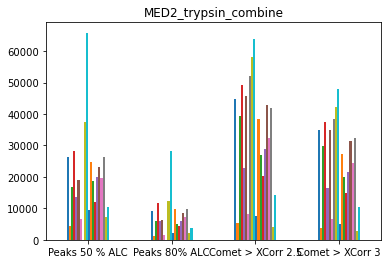

In [100]:
# bar plot of residue totals
# there is no isoleucine (I) in Peaks data, which is why L is really big and I is 0


x_labels = ['Peaks 50 % ALC', 'Peaks 80% ALC', 'Comet > XCorr 2.5', 'Comet > XCorr 3']


ax = AA.plot(kind="bar", title = 'MED2_trypsin_combine')
plt.xticks(rotation=0)
ax.get_legend().remove()
ax.set_xticklabels(x_labels)

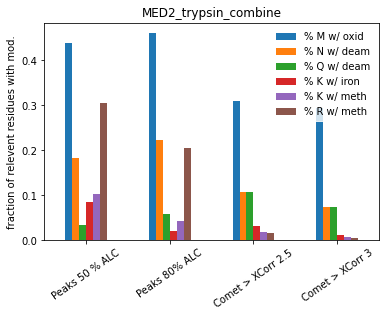

In [130]:
# bar plot of relative modifications

x_labels = ['Peaks 50 % ALC', 'Peaks 80% ALC', 'Comet > XCorr 2.5', 'Comet > XCorr 3']


ax = ptm.plot(kind="bar", title = 'MED2_trypsin_combine')
plt.xticks(rotation=35)
#ax.get_legend().remove()
ax.set_xticklabels(x_labels)
ax.set_ylabel('fraction of relevent residues with mod.')
legend = plt.legend()
legend.get_frame().set_edgecolor('1.0')

In [146]:
AA.style.background_gradient(cmap ='viridis')

In [103]:
ptm.style.background_gradient(cmap ='viridis')

In [ ]:
# make the AA dataframe contain relative AA compositions for each dataset

